In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = "/content/drive/My Drive/RottenTom_Sentiment-analysis/Data/train.tsv"

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [0]:
data = pd.read_csv(PATH,sep='\t')

In [0]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


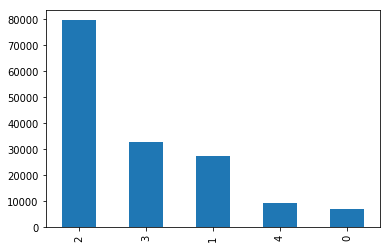

In [0]:
data.Sentiment.value_counts().plot.bar()

In [0]:
data['token_size'] = data['Phrase'].apply(lambda x: len(x.split(' ')))
data.head()
data['token_size'].max()

52

In [0]:
# sampling
data = data.sample(n=50000)
data.head()

,PhraseId,SentenceId,Phrase,Sentiment,token_size
17998,17999,784,a beer,2,2
39832,39833,1903,have made it an exhilarating,4,5
30578,30579,1420,a dualistic battle between good and evil,3,7
143586,143587,7794,"Ratliff 's two previous titles , Plutonium Cir...",3,20
32888,32889,1541,"never quite makes it to the boiling point , bu...",3,23


In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab(object):
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(data['Phrase'].values.tolist())

# examples of what is in the vocab
inputs.vocab[40:50]

['100-minute',
 '101',
 '102-minute',
 '103-minute',
 '104',
 '105',
 '10th-grade',
 '11',
 '110',
 '112-minute']

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["Phrase"].values.tolist()]

In [0]:
input_tensor[0:10]

[[4165, 5108],
 [9422, 10988, 10341, 4571, 8099],
 [4165, 7558, 5065, 5185, 9066, 4585, 8033],
 [3063,
  21,
  16288,
  12857,
  15971,
  25,
  2947,
  922,
  4585,
  3019,
  1036,
  14425,
  9584,
  12361,
  8657,
  17309,
  25,
  6436,
  6342,
  25],
 [11705,
  13159,
  11021,
  10341,
  15974,
  15798,
  5357,
  12619,
  25,
  5600,
  11040,
  15974,
  15530,
  4165,
  9066,
  14494,
  8657,
  11479,
  11902,
  10350,
  13869,
  15938,
  30],
 [11791, 10659],
 [14667, 10341],
 [14797, 10220, 13631],
 [13239, 8785],
 [11488]]

In [0]:
len(input_tensor)

50000

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

51


In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [0]:
input_tensor[ : 5]

[array([4165, 5108,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]),
 array([ 9422, 10988, 10341,  4571,  8099,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([4165, 7558, 5065, 5185, 9066, 4585, 8033,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [0]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# convert targets to one-hot encoding vectors
Sentiments = list(set(data.Sentiment.unique()))
num_sentiments = len(Sentiments)

# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(sen) & set(Sentiments) for sen in data[['Sentiment']].values]
bin_sentiments = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_sentiments.tolist())

In [0]:
type(target_tensor)
# counter = 0
# for ten in target_tensor:
#     for i in ten:
#       if (i == 0 or i == 1):
#         print(i)
#       else:
#         print('found') 

numpy.ndarray

In [0]:
get_sentiment = lambda t: np.argmax(t)

In [0]:
get_sentiment(target_tensor[0])

2

In [0]:
sentiment_dict = {0: 'negative', 1: 'somewhat negative', 2: 'neutral', 
                  3: 'somewhat positive', 4: 'positive'}

In [0]:
sentiment_dict[get_sentiment(target_tensor[1])]

'positive'

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
# Data instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


# Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [0]:
i = iter(train_dataset)
text,label,text_len = i.next()
print(text.shape)
print(label.shape)
print(text[0].shape)
print(text[0])
print(label[0])
print(text_len)

torch.Size([64, 51])
torch.Size([64, 5])
torch.Size([51])
tensor([16273,  9690,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
tensor([0, 0, 1, 0, 0])
tensor([ 2,  4, 18,  3,  1,  7, 32, 15,  2,  3,  4,  2,  3, 11,  3,  3,  3,  3,
         8, 13,  2,  2,  6, 12,  7,  4, 12,  9,  2,  6,  2,  2,  3,  3, 16,  7,
         3,  1, 13,  5,  8,  6, 21, 18,  2,  2,  1,  2,  3,  1,  2,  5,  3,  7,
        23,  1,  3,  2, 21, 10,  2,  4, 25,  1])


In [0]:
import torch.nn as nn

class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(SentimentGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.dropout = nn.Dropout(p=0.5)
        # self.fc = nn.Linear(self.hidden_units, self.output_size)
        self.fc = nn.Linear(self.hidden_units, 1000)
        self.fc_2 = nn.Linear(1000, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        out = self.fc_2(out)

        return out, self.hidden

In [0]:
import torch

In [0]:
print(len(input_tensor_train))
print(len(input_tensor_val))
print(len(input_tensor_test))
len(inputs.word2idx)

40000
5000
5000


17367

In [0]:
# parameters
TRAIN_BUFFER_SIZE = 40000 # len(input_tensor_train)
VAL_BUFFER_SIZE = 5000 # len(input_tensor_val)
TEST_BUFFER_SIZE = 5000 # len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = 17367 #len(inputs.word2idx)
target_size = 5 # num_emotions

In [0]:
len(inputs.word2idx)

17367

In [0]:
# sort batch function to be able to use with pad_packed_sequence
# batch elements ordered decreasingle by their length

def sort_batch(X, y, lengths):
    "sort the batch by length"
    
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
model = SentimentGRU(vocab_inp_size + 1, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

RuntimeError: ignored

In [0]:
# Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01,weight_decay=0.0001)

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

RuntimeError: ignored

In [0]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [0]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3276
Epoch 1 Batch 100 Val. Loss 0.2447
Epoch 1 Batch 200 Val. Loss 0.2150
Epoch 1 Batch 300 Val. Loss 0.2532
Epoch 1 Batch 400 Val. Loss 0.2650
Epoch 1 Batch 500 Val. Loss 0.2670
Epoch 1 Batch 600 Val. Loss 0.2913
Epoch 1 Loss 0.2580 -- Train Acc. 50.0000 -- Val Acc. 50.0000
Time taken for 1 epoch 40.811805963516235 sec

Epoch 2 Batch 0 Val. Loss 0.2473
Epoch 2 Batch 100 Val. Loss 0.2639
Epoch 2 Batch 200 Val. Loss 0.2433
Epoch 2 Batch 300 Val. Loss 0.2245
Epoch 2 Batch 400 Val. Loss 0.2362
Epoch 2 Batch 500 Val. Loss 0.2525
Epoch 2 Batch 600 Val. Loss 0.2661
Epoch 2 Loss 0.2573 -- Train Acc. 50.0000 -- Val Acc. 50.0000
Time taken for 1 epoch 40.42712736129761 sec

Epoch 3 Batch 0 Val. Loss 0.2686
Epoch 3 Batch 100 Val. Loss 0.2551
Epoch 3 Batch 200 Val. Loss 0.2584
Epoch 3 Batch 300 Val. Loss 0.2553
Epoch 3 Batch 400 Val. Loss 0.2857
Epoch 3 Batch 500 Val. Loss 0.2529
Epoch 3 Batch 600 Val. Loss 0.2084
Epoch 3 Loss 0.2572 -- Train Acc. 50.0000 -- Val Acc. 

In [0]:
PATH_TO_Model = "/content/drive/My Drive/RottenTom_Sentiment-analysis/SentimentGRUModel"
torch.save(model, PATH_TO_Model)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SentimentGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
